In [264]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [265]:
# Path to your Excel file
file_path = 'EIOPA_RFR_20240229_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="S", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA IT without VA, FEB'})
rt = np.array(df).T
rt = np.array(rt, np.float64)

In [266]:
def simulate_gbm_vec(F0, r, sigma, dt, N, m_MC):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z = np.random.normal(size=m_MC)
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

In [267]:
# Parameters
m_MC = 1 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
F0 = 100000 # Initial value of the fund
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
rt = rt[0, :N] # Time-varying risk-free rate
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio

In [268]:
# Simulate equity and property paths
EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)

# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt

(50, 1)(50, 1)


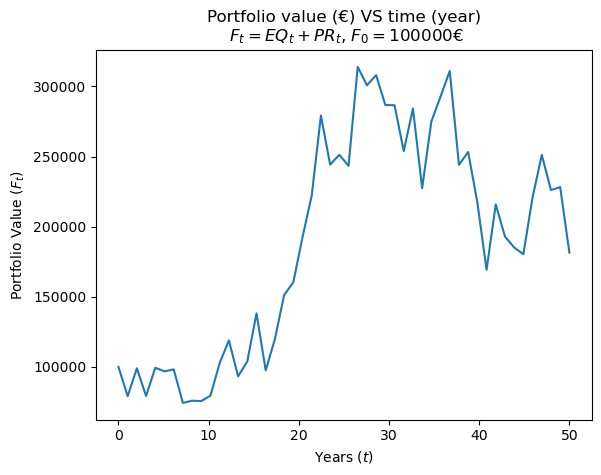

In [269]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as Ft
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()

## Liabilities :

In [270]:
def initialize_policy_values(N):
    """Initialize policy values for N policyholders"""
    return 100000 # np.full(N, 100000)  # Assuming an initial fund value of 100,000 euros for each policy

def mortality_survival_probs(life_table):
    """Compute survival probabilities from the provided life table"""
    p_survive = np.exp(-np.array(life_table))
    # p_survive = np.insert(p_survive, 0, 1.0)  # Inserting 1.0 at the beginning for birth
    return p_survive

def simulate_lapses(N, Ft, lapse_rate):
    """Simulate lapses for N policyholders"""
    nb_lapse = np.random.binomial(N, lapse_rate)
    loss_lapse = nb_lapse * (Ft - 20)  # Penalty of 20 euros per lapse
    New_nb_of_people_after_lapse = N - nb_lapse
    return loss_lapse, New_nb_of_people_after_lapse

def simulate_deaths(N, Ft, survival_probs, t):
    """Simulate deaths for N policyholders at time t"""
    policyholders_alive = np.random.binomial(N, survival_probs[t])
    nb_out = N - policyholders_alive
    cost_death = np.maximum(Ft, 100000) * nb_out  # Death benefit is maximum between Ft and premium payed at the beginning
    return policyholders_alive, cost_death

def simulate_expenses(t, policyholders_alive, Ft, loss_lapse, cost_death, discount_rate, rd_rate, comm_rate, last_expense):
    """Simulate expenses for policyholders"""
    # Discount factor for the current year
    discount_factor = 1 / ((1 + discount_rate) ** t)
    # Expense related to the regular deduction
    cash_flow_rd = policyholders_alive * (Ft - 20) * rd_rate * discount_factor
    # Expense related to commissions to the distribution channel
    expense_comm = comm_rate * policyholders_alive * Ft * discount_factor
    # Death costs discounted
    cost_death = cost_death * discount_factor
    # Lapse costs discounted 
    loss_lapse = loss_lapse * discount_factor
    # Total expenses (yearly cost + comm expenses + death costs + lapse costs)
    total_expense = last_expense * rd_rate * policyholders_alive * discount_factor + expense_comm + cost_death + loss_lapse
    # Total cash flow
    cash_flow = total_expense - cash_flow_rd
    # Discounted cash flow for the current year
    discounted_cash_flow = cash_flow # * discount_factor
    return discounted_cash_flow

In [271]:
# Parameters
Nb = 900  # Number of policyholders
T = 50  # Projection horizon
lapse_rate = 0.15  # Lapse rate
rd_rate = 0.022  # Expense rate
comm_rate = 0.014  # Commission rate
discount_rate = 0.01  # Risk-free discount rate (can be derived from the yield curve)
inflation_rate = 0.02  # Inflation rate

# Initialize policy values and expenses
Ft = initialize_policy_values(Nb)
last_expense = 50  # Initial unitary cost per policy

# Load mortality rates from the life table
# Here it's dummy data, replace with actual life table 
life_table = np.array([
    0.0102, 0.0107, 0.0112, 0.0117, 0.0122,  # Age 60-64
    0.0127, 0.0133, 0.0140, 0.0147, 0.0154,  # Age 65-69
    0.0162, 0.0170, 0.0180, 0.0190, 0.0202,  # Age 70-74
    0.0215, 0.0231, 0.0249, 0.0269, 0.0290,  # Age 75-79
    0.0314, 0.0342, 0.0373, 0.0407, 0.0446,  # Age 80-84
    0.0489, 0.0537, 0.0590, 0.0648, 0.0711,  # Age 85-89
    0.0781, 0.0857, 0.0938, 0.1028, 0.1126,  # Age 90-94
    0.1232, 0.1348, 0.1473, 0.1608, 0.1752,  # Age 95-99
    0.1906, 0.2068, 0.2239, 0.2419, 0.2607,  # Age 100-104
    0.2806, 0.3008, 0.3335, 0.3550, 0.3800   # Age 105-109
]) 

In [272]:
# Simulate liabilities over the projection horizon
total_costs = []
New_nb_of_people_after_lapse_and_after_deaths = Nb # INITIALISATION

tot_liabilities = np.zeros(T)

for n in range(Nb):
    for t in range(T):
        Ft = fund_value[0, t]
        # print(str(New_nb_of_people_after_lapse_and_after_deaths))
        Nb = New_nb_of_people_after_lapse_and_after_deaths # at each loop
        survival_probs = mortality_survival_probs(life_table)
        loss_lapse, New_nb_of_people_after_lapse = simulate_lapses(Nb, Ft, lapse_rate)
        New_nb_of_people_after_lapse_and_after_deaths, cost_death = simulate_deaths(New_nb_of_people_after_lapse, Ft, survival_probs, t)
        cash_flow = simulate_expenses(t, New_nb_of_people_after_lapse_and_after_deaths, Ft, loss_lapse, cost_death, discount_rate, rd_rate, comm_rate, last_expense)
        total_costs.append(np.sum(cash_flow))
        last_expense *= (1 + inflation_rate)  # Update expense for next year
        tot_liabilities[t] = tot_liabilities[t] + total_costs[-1]
    total_costs = []

In [273]:
tot_liabilities.shape

(50,)

In [274]:
tot_liabilities

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

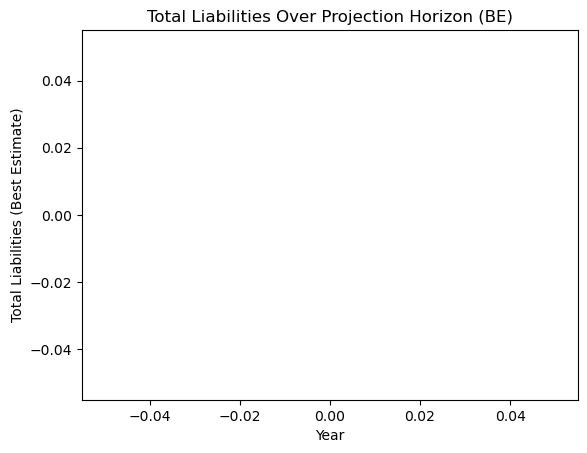

In [275]:
# Plot total costs over time
plt.plot(range(T), tot_liabilities)
plt.xlabel('Year')
plt.ylabel('Total Liabilities (Best Estimate)')
plt.title('Total Liabilities Over Projection Horizon (BE)')
plt.show()

In [276]:
fund_value[0, 4]

99406.55738843724